# Importing the needed libraries

In [ ]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image

# Defining Sigmoid activation function and it's derivative

In [ ]:
# Sigmoid
class Sigmoid():
  def __call__(self, x):
    return 1 / (1 + np.exp(-x))

  def gradient(self, x):
    return self.__call__(x) * (1 - self.__call__(x))


# Defining MSE & PSNR as loss function

In [ ]:
def MSE(actual, predicted):
  # Avoid division by zero
  predicted = np.clip(predicted, 1e-15, 1 - 1e-15)
  sum_square_error = 0.0
  for i in range(len(actual)):
    sum_square_error += (actual[i] - predicted[i])**2.0
  mean_square_error = (1.0 / (2*len(actual))) * sum_square_error
  return mean_square_error

In [ ]:
def PSNR(actual, predicted):
  return 10*np.log10(1**2/MSE(actual, predicted))

# Defining a function for adding the pictures horozontally

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('L', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

# Defining the function for dividing the image into segments

In [ ]:
def crop(im, d):
  dimentions = np.array(im)
  x, y = dimentions.shape
  cropped_image = list([])
  for i in range(0, x, d):
    for j in range(0, y, d):
      box = (i, j, i+d, j+d)
      b = im.crop(box)
      c = np.array(b)
      cropped_image.append(c)
  cropped_image = np.array(cropped_image)

  return cropped_image

# Defining the function to sticking the segments into the complete image

In [ ]:
def stick_8_pixels(x):
  x = np.array(x)
  x = x.reshape(-1, 8, 8)
  X = list(range(32))
  for i in range(32):
    X[i] = np.vstack(x[32*i : 32*(i+1)])
  X = np.hstack(X[:])
  return X

# Writing the MLP

In [ ]:
class MultilayerPerceptron():
  """Multilayer Perceptron classifier. A fully-connected neural network with one hidden layer.
  Unrolled to display the whole forward and backward pass.
  Parameters:
  -----------
  n_hidden: int:
      The number of processing nodes (neurons) in the hidden layer.
  learning_rate: float
      The step length that will be used when updating the weights.
  """
  def __init__(self, n_input, n_hidden, n_output, learning_rate=0.01):
    self.n_hidden = n_hidden
    self.learning_rate = learning_rate
    self.hidden_activation = Sigmoid()
    self.output_activation = Sigmoid()
    self.sigmoid = Sigmoid()
    # Initializing the weights
    # Hidden layer
    limit   = 1 / math.sqrt(n_input)
    self.W  = np.random.uniform(-limit, limit, (n_input, self.n_hidden))
    self.w0 = np.random.uniform(-limit, limit, (1, self.n_hidden))
    # Output layer
    limit   = 1 / math.sqrt(self.n_hidden)
    self.V  = np.random.uniform(-limit, limit, (self.n_hidden, n_output))
    self.v0 = np.random.uniform(-limit, limit, (1, n_output))

  def train_pass(self, X, y):

    # ..............
    #  Forward Pass
    # ..............

    # HIDDEN LAYER
    hidden_input = np.dot(X, self.W) + self.w0
    hidden_output = self.hidden_activation(hidden_input)
    # OUTPUT LAYER
    output_layer_input = np.dot(hidden_output, self.V) + self.v0
    y_pred = self.output_activation(output_layer_input)

    # ...............
    #  Backward Pass
    # ...............

    # OUTPUT LAYER
    delta_v = (y - y_pred)*self.output_activation.gradient(output_layer_input)
    # HIDDEN LAYER
    delta_in = np.dot(delta_v, self.V.T)
    delta_w = delta_in*self.sigmoid.gradient(hidden_input)

    # Update weights
    self.V += self.learning_rate * np.dot(hidden_output.T, delta_v)
    self.v0 += self.learning_rate * delta_v
    X = X.reshape(64, 1)
    self.W += self.learning_rate * np.dot(X, delta_w)
    self.w0 += self.learning_rate * delta_w

  # Use the trained model to predict labels of X
  def predict(self, X):
    # Forward pass:
    hidden_input = np.dot(X, self.W) + self.w0
    hidden_output = self.hidden_activation(hidden_input)
    output_layer_input = np.dot(hidden_output, self.V) + self.v0
    y_pred = self.output_activation(output_layer_input)
    return y_pred

# Model with 32 hidden neurons

## Training the model

mean loss (PSNR) between all images in 1th epoch ====> 26.182588927068803
current_psnr - last_psnr ================================> 26.182588927068803

mean loss (PSNR) between all images in 2th epoch ====> 28.13367307770139
current_psnr - last_psnr ================================> 1.9510841506325853

mean loss (PSNR) between all images in 3th epoch ====> 28.80329684772081
current_psnr - last_psnr ================================> 0.6696237700194203

mean loss (PSNR) between all images in 4th epoch ====> 29.50827227509633
current_psnr - last_psnr ================================> 0.7049754273755227

mean loss (PSNR) between all images in 5th epoch ====> 30.04686477504233
current_psnr - last_psnr ================================> 0.5385924999459988

mean loss (PSNR) between all images in 6th epoch ====> 30.405325042933324
current_psnr - last_psnr ================================> 0.35846026789099383

mean loss (PSNR) between all images in 7th epoch ====> 30.690401744748165
current_psn

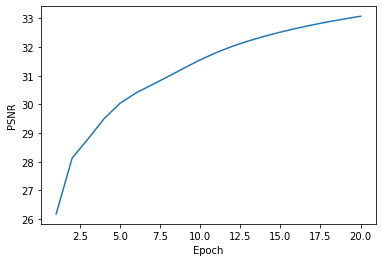

In [ ]:
# Learning Loop
max_epochs = 100

model1 = MultilayerPerceptron(n_input=64,
                             n_hidden=32,
                             n_output=64,
                             learning_rate=0.01)

psnr_list = list([])
last_psnr = 0.0
for epoch in range(max_epochs):
  for i in range(91):
    im = Image.open(f'train ({i}).jpg')
    cropped_im_arr = crop(im, 8)
    cropped_im_arr = cropped_im_arr.reshape(-1, 64)
    for X in cropped_im_arr:
      X = np.array(X)
      input = X.astype('float32')/255
      model1.train_pass(input, input)

  sum_psnr = 0.0
  for i in range(91):
    im = Image.open(f'train ({i}).jpg')
    cropped_im_arr = crop(im, 8)
    cropped_im_arr = cropped_im_arr.reshape(-1, 64)
    input = cropped_im_arr.astype('float32')/255
    y_pred = model1.predict(input)
    input =input.reshape(-1)
    y_pred = y_pred.reshape(-1)
    sum_psnr += PSNR(input, y_pred)

  psnr_list.append(sum_psnr/91)
  print(f'mean loss (PSNR) between all images in {epoch+1}th epoch ====> {sum_psnr/91}')
  print(f'current_psnr - last_psnr ================================> {sum_psnr/91 - last_psnr}')
  print()

  if (sum_psnr/91 - last_psnr) <0.1:
    print('Not that much change')
    print()
    plt.plot(range(1, epoch+2), psnr_list)
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.show()
    break
  elif (sum_psnr/91)>40:
    print('Well enough')
    print()
    plt.plot(range(1, epoch+2), psnr_list)
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.show()
    break
  else:
    last_psnr = sum_psnr/91

else:
  print('End of epochs')
  print()
  plt.plot(range(1, epoch+2), psnr_list)
  plt.xlabel('Epoch')
  plt.ylabel('PSNR')
  plt.show()

## Showing the results

              Real                           predicted


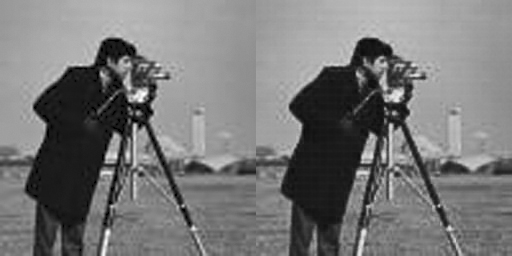

PSNR: 38.62298140540785



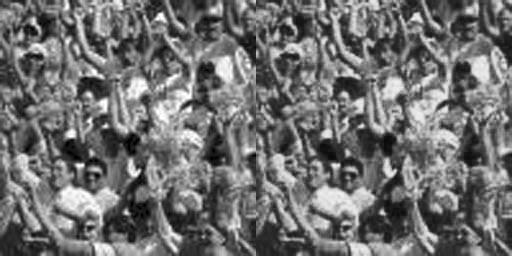

PSNR: 35.6851237735148



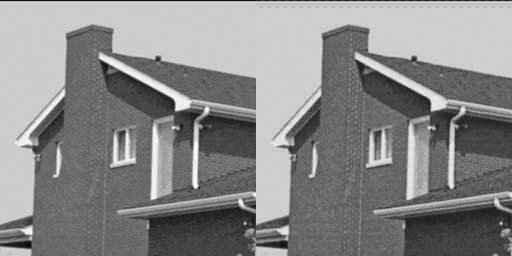

PSNR: 36.96580552239951



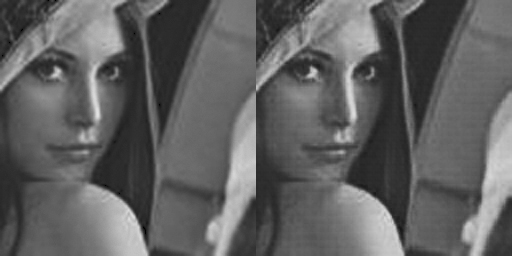

PSNR: 41.79967821700403



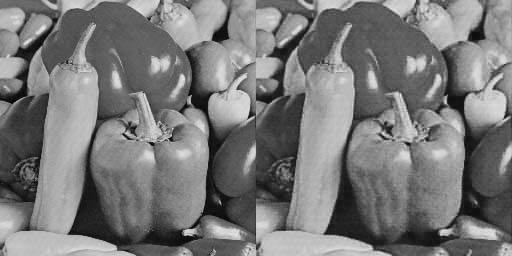

PSNR: 35.01517564558625

Mean PSNR =======> 37.61775291278249


In [ ]:
print('              Real                           predicted')
sum_psnr = 0
im = Image.open('camera.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model1.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('crowd.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model1.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('house.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model1.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('lena.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model1.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('pepper.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model1.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

print(f'Mean PSNR =======> {sum_psnr/5}')

# Model with 16 hidden neurons

## Training the model

mean loss (PSNR) between all images in 1th epoch ====> 26.022182918912712
current_psnr - last_psnr ================================> 26.022182918912712

mean loss (PSNR) between all images in 2th epoch ====> 27.667860257365316
current_psnr - last_psnr ================================> 1.6456773384526038

mean loss (PSNR) between all images in 3th epoch ====> 28.2600038611446
current_psnr - last_psnr ================================> 0.5921436037792844

mean loss (PSNR) between all images in 4th epoch ====> 28.728780192418167
current_psnr - last_psnr ================================> 0.4687763312735669

mean loss (PSNR) between all images in 5th epoch ====> 29.249069300288873
current_psnr - last_psnr ================================> 0.5202891078707061

mean loss (PSNR) between all images in 6th epoch ====> 29.628477541152055
current_psnr - last_psnr ================================> 0.3794082408631816

mean loss (PSNR) between all images in 7th epoch ====> 29.933287110264224
current_ps

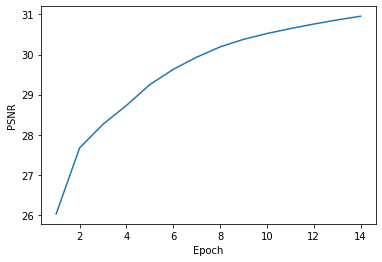

In [ ]:
# Learning Loop
max_epochs = 100

model2 = MultilayerPerceptron(n_input=64,
                             n_hidden=16,
                             n_output=64,
                             learning_rate=0.01)

psnr_list = list([])
last_psnr = 0.0
for epoch in range(max_epochs):
  for i in range(91):
    im = Image.open(f'train ({i}).jpg')
    cropped_im_arr = crop(im, 8)
    cropped_im_arr = cropped_im_arr.reshape(-1, 64)
    for X in cropped_im_arr:
      X = np.array(X)
      input = X.astype('float32')/255
      model2.train_pass(input, input)

  sum_psnr = 0.0
  for i in range(91):
    im = Image.open(f'train ({i}).jpg')
    cropped_im_arr = crop(im, 8)
    cropped_im_arr = cropped_im_arr.reshape(-1, 64)
    input = cropped_im_arr.astype('float32')/255
    y_pred = model2.predict(input)
    input =input.reshape(-1)
    y_pred = y_pred.reshape(-1)
    sum_psnr += PSNR(input, y_pred)

  psnr_list.append(sum_psnr/91)
  print(f'mean loss (PSNR) between all images in {epoch+1}th epoch ====> {sum_psnr/91}')
  print(f'current_psnr - last_psnr ================================> {sum_psnr/91 - last_psnr}')
  print()

  if (sum_psnr/91 - last_psnr) <0.1:
    print('Not that much change')
    print()
    plt.plot(range(1, epoch+2), psnr_list)
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.show()
    break
  elif (sum_psnr/91)>40:
    print('Well enough')
    print()
    plt.plot(range(1, epoch+2), psnr_list)
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.show()
    break
  else:
    last_psnr = sum_psnr/91

else:
  print('End of epochs')
  print()
  plt.plot(range(1, epoch+2), psnr_list)
  plt.xlabel('Epoch')
  plt.ylabel('PSNR')
  plt.show()

## Showing the results

              Real                           predicted


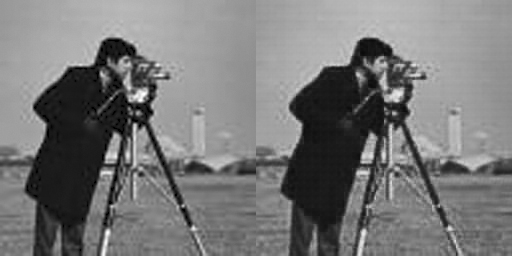

PSNR: 36.0886659811072



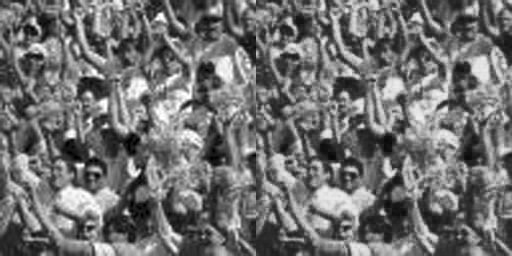

PSNR: 33.10941781142396



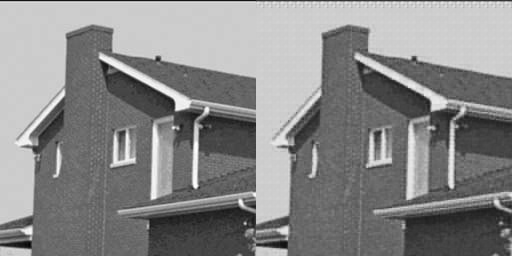

PSNR: 34.415000691543504



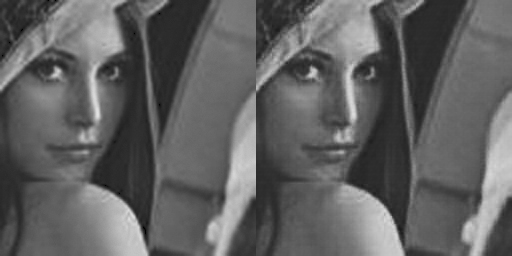

PSNR: 40.57657137631306



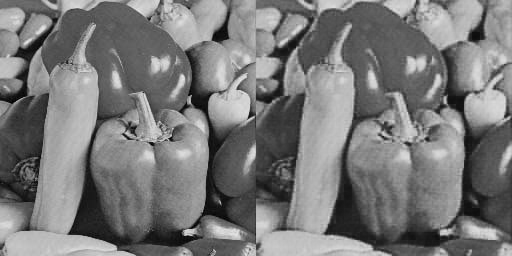

PSNR: 32.42096628790722

Mean PSNR =======> 35.322124429658984


In [ ]:
print('              Real                           predicted')
sum_psnr = 0
im = Image.open('camera.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model2.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('crowd.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model2.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('house.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model2.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('lena.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model2.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('pepper.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model2.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

print(f'Mean PSNR =======> {sum_psnr/5}')

# Model with 4 hidden neurons

## Training the model

mean loss (PSNR) between all images in 1th epoch ====> 22.533766592411375
current_psnr - last_psnr ================================> 22.533766592411375

mean loss (PSNR) between all images in 2th epoch ====> 22.834785665192722
current_psnr - last_psnr ================================> 0.3010190727813473

mean loss (PSNR) between all images in 3th epoch ====> 22.9578898776978
current_psnr - last_psnr ================================> 0.1231042125050763

mean loss (PSNR) between all images in 4th epoch ====> 23.02508920073353
current_psnr - last_psnr ================================> 0.06719932303573017

mean loss (PSNR) between all images in 5th epoch ====> 23.068039171105532
current_psnr - last_psnr ================================> 0.04294997037200332

Not that much change



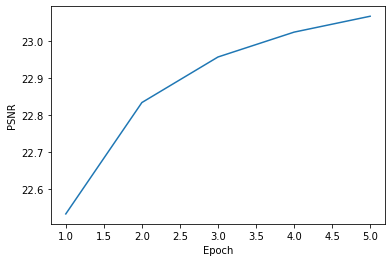

In [ ]:
# Learning Loop
max_epochs = 100

model3 = MultilayerPerceptron(n_input=64,
                             n_hidden=4,
                             n_output=64,
                             learning_rate=0.01)

psnr_list = list([])
last_psnr = 0.0
for epoch in range(max_epochs):
  for i in range(91):
    im = Image.open(f'train ({i}).jpg')
    cropped_im_arr = crop(im, 8)
    cropped_im_arr = cropped_im_arr.reshape(-1, 64)
    for X in cropped_im_arr:
      X = np.array(X)
      input = X.astype('float32')/255
      model3.train_pass(input, input)

  sum_psnr = 0.0
  for i in range(91):
    im = Image.open(f'train ({i}).jpg')
    cropped_im_arr = crop(im, 8)
    cropped_im_arr = cropped_im_arr.reshape(-1, 64)
    input = cropped_im_arr.astype('float32')/255
    y_pred = model3.predict(input)
    input =input.reshape(-1)
    y_pred = y_pred.reshape(-1)
    sum_psnr += PSNR(input, y_pred)

  psnr_list.append(sum_psnr/91)
  print(f'mean loss (PSNR) between all images in {epoch+1}th epoch ====> {sum_psnr/91}')
  print(f'current_psnr - last_psnr ================================> {sum_psnr/91 - last_psnr}')
  print()

  if (sum_psnr/91 - last_psnr) <0.05:
    print('Not that much change')
    print()
    plt.plot(range(1, epoch+2), psnr_list)
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.show()
    break
  elif (sum_psnr/91)>40:
    print('Well enough')
    print()
    plt.plot(range(1, epoch+2), psnr_list)
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.show()
    break
  else:
    last_psnr = sum_psnr/91

else:
  print('End of epochs')
  print()
  plt.plot(range(1, epoch+2), psnr_list)
  plt.xlabel('Epoch')
  plt.ylabel('PSNR')
  plt.show()

## Showing the results

              Real                           predicted


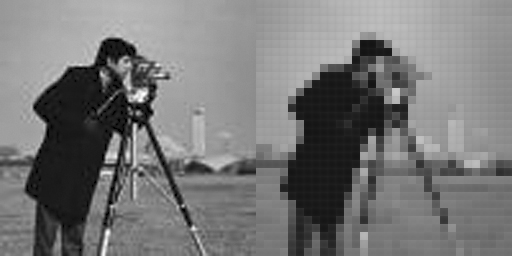

PSNR: 25.28370613505662



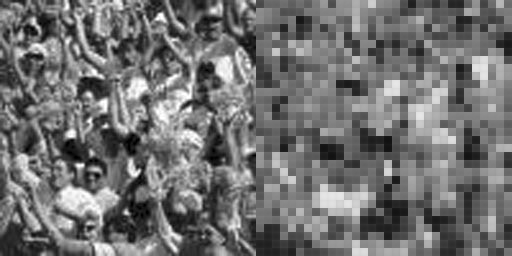

PSNR: 20.768150406947782



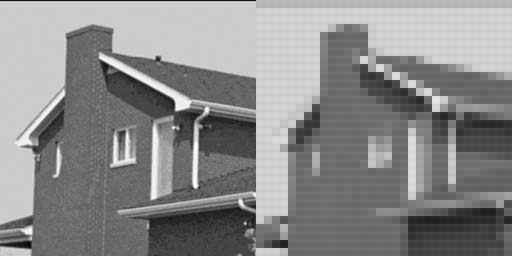

PSNR: 23.90053404060824



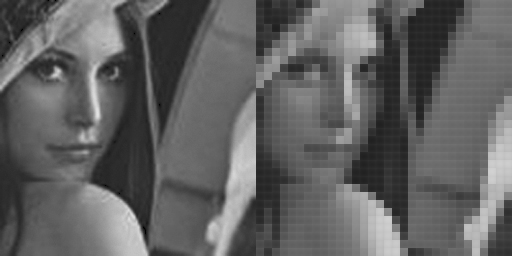

PSNR: 28.643533625925862



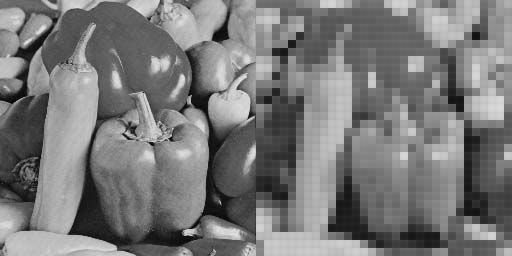

PSNR: 23.659092982090915

Mean PSNR =======> 24.45100343812588


In [ ]:
print('              Real                           predicted')
sum_psnr = 0
im = Image.open('camera.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model3.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('crowd.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model3.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('house.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model3.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('lena.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model3.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

im = Image.open('pepper.jpg')
croppedim = crop(im, 8)
croppedim = croppedim.reshape(-1, 64)
input = croppedim.astype('float32')/255
y_pred = model3.predict(input)
pred = (y_pred*255).astype(np.uint8)
pred = stick_8_pixels(pred)
display(get_concat_h(im, Image.fromarray(pred)))
input =input.reshape(-1)
y_pred = y_pred.reshape(-1)
sum_psnr += PSNR(input, y_pred)
print(f'PSNR: {PSNR(input, y_pred)}')
print()

print(f'Mean PSNR =======> {sum_psnr/5}')